# Robust MPC full code

In [1]:
# Import all the packages we need
import numpy as np
import pandas as pd
from typing import Optional, Tuple

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import pickle
from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from torch.nn import ReLU

# from pytorch_forecasting.metrics.quantile import QuantileLoss

# For LSTM
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

from sklearn.preprocessing import StandardScaler
import torch.autograd.functional as F

# For TFT
from tqdm import tqdm_notebook as tqdm

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


# import functions
from TiDE import TideModule, quantile_loss, TiDE_forward
from sys_model import nominal_model, nominal_model_recur, system_model
from RobustMPC import RMPC_iteration
from RobustMPC_pytorch import RMPC_pytorch_iteration
from utils import sigmoid, LossParameters, GlobalState, BarrierParam


cuda is available


## Load pre-trained models

### Load nominal model

In [2]:
# # Window = 1 =================================================
# # Open the pickle file
# with open('nominal_params_w1_more.pkl', 'rb') as file:
#     # 2. Load the data from the pickle file
#     nominal_params = pickle.load(file)
# # Load nominal TiDE model
# nominal_TiDE = nominal_params['model'].to("cpu")
# nominal_TiDE.load_state_dict(torch.load('nominal_params_w1_more.pth'))
# nominal_TiDE.eval()
# window = 10
# P = 10

# Window = 1, OK ============================================
# Open the pickle file
with open('nominal_params_w10_noisy_stable.pkl', 'rb') as file:
    # 2. Load the data from the pickle file
    nominal_params = pickle.load(file)
# Load nominal TiDE model
nominal_TiDE = nominal_params['model'].to("cpu")
nominal_TiDE.load_state_dict(torch.load('nominal_params_w10_noisy_stable.pth'))
nominal_TiDE.eval()
window = 10





### Load tube model

In [3]:
# Open the pickle file
with open('controlled_quantile_params_w10.pkl', 'rb') as file:
    # 2. Load the data from the pickle file
    tube_params = pickle.load(file)
# Load nominal TiDE model
tube_TiDE = tube_params['model'].to("cpu")
tube_TiDE.load_state_dict(torch.load('controlled_quantile_TiDE_w10.pth'))
tube_TiDE = tube_TiDE.eval()
P = 10

### Load reference trajectory

In [4]:
path = ''
data = pd.read_pickle(path + 'open_loop_data_SISO.pkl')

data["y"][1:] = data["y"][0:-1]
Ref_traj = data["y"].values*3
Ref_traj = np.concatenate((np.zeros((20)),Ref_traj))

### Objective function with checking constraint

In [5]:

# def RMPC_obj_TiDE(u_hat:np.array, # future u values within the control horizon, length = M; this should be the warm start version
#                 u_past:np.array, # past u
#                 x_past: np.array, # past state of x, size (N,window)
#                 SP_hat:np.array, # Reference trajectory, length = P
#                 P, # Predictive Horizon
#                 NN_Nominal, # Nominal TiDE model that we're using
#                 tube_model = None,
#                 error_history = None,
#                 x_max=None,
#                 x_min=None,
#                 u_max=None,
#                 u_min=None
# ):
    
#     # convert u_hat into tensor and set u_hat as variable
#     u_hat = torch.tensor(u_hat.reshape(-1,1), requires_grad=True, dtype=torch.float32)
#     u_hat_in = u_hat.unsqueeze(0)
    
#     # knit past and future covariate into the input format for TiDE
#     past_cov = torch.tensor(np.concatenate((x_past,u_past), axis = 0),dtype=torch.float32).transpose(1,0).unsqueeze(0)
#     # TiDE prediction
#     x_hat = NN_Nominal([past_cov,u_hat_in,None])
    
#     global x_hat_global
#     x_hat_global = x_hat[0,:,:,1]
    

#     # compute objective value
#     x_hat = x_hat[0,:,0,1]
#     u_hat_temp = u_hat_in[0,:,0].reshape(-1,1) 

#     u = u_hat_temp[0].reshape(-1,1)
#     u_hat0 = torch.concatenate((u,u_hat_temp)) # append the computed u with the history u
    
#     Obj = 100 * torch.sum((x_hat-torch.tensor(SP_hat,dtype=torch.float32))**2) + 1*torch.sum((u_hat0[1:]-u_hat0[0:-1])**2)
#     Obj.backward()

#     return Obj.item(), u_hat.grad.numpy().reshape(-1)

# def x_bound_check(u, u_past, tube_model, error_history, x_max, x_min, x_past, u_max, u_min, NN_nominal):
#     # u require_grad
#     # the u input to the constraint function is the scaled u. 
#     # we are using the scaled u to compute x_pred, but using the u in original scale to compute tube width
#     # x_past is scaled.
#     # u_past is in original scale already
    
#     # convert u_hat into tensor and set u_hat as variable
#     u_hat_in = u.unsqueeze(0)
    
#     # ============ x_pred ====================
#     u_past_s = -1 + 2 * ((u_past - u_min.reshape(-1,1)) / (u_max-u_min).reshape(-1,1)) # scaled u_past
#     past_cov = torch.tensor(np.concatenate((x_past,u_past_s), axis = 0),dtype=torch.float32).transpose(1,0).unsqueeze(0)
#     # TiDE prediction
#     u_hat_s = u_hat_in # from original to scaled
#     xs_hat = NN_nominal([past_cov,u_hat_s,None])[0,:,:,1] # scaled pred median of x1 and x2
#     # scale x_hat to original scale
#     x_max_torch = torch.tensor(x_max).reshape(1,-1)
#     x_min_torch = torch.tensor(x_min).reshape(1,-1)
#     x_hat = ((xs_hat + 1).reshape(-1,2) * 0.5 * ((x_max_torch-x_min_torch).reshape(-1,2)) + x_min_torch.reshape(-1,2)) # shape = [P,2]
    

#     # ============ tube_pred =================
#     # convert error_history to original scale
#     if np.all(error_history) == 0:
#         error_history = error_history.transpose(1,0) # shape = [10,2]
#     else:
#         error_history = error_history.transpose(1,0).reshape(-1,2)
#     #     error_history = (error_history_s.transpose(1,0) + 1).reshape(-1,2) * 0.5 * ((x_max-x_min).reshape(-1,2)) + x_min.reshape(-1,2) # shape = [10,2]

#     # convert u_past into original scale
#     # u_past = ((u_past_s + 1).reshape(-1,1)*0.5*(u_max-u_min).reshape(-1,1) + u_min.reshape(-1,1)) # shape = [P, 1]
#     past_cov_error = torch.tensor(np.concatenate((error_history,u_past), axis = 1), dtype=torch.float32).unsqueeze(0) # shape = [1,P,3]
    
#     # convert u into original scale
#     u_max = torch.tensor(u_max)
#     u_min = torch.tensor(u_min)
#     u_hat = ((u + 1).reshape(-1,1)*0.5*(u_max-u_min).reshape(-1,1) + u_min.reshape(-1,1)).unsqueeze(0).to(torch.float32) # shape = [1, P, 1]
    
#     # predict tube size
#     error_hat = tube_model([past_cov_error,u_hat,None])[0,:,:,:] # scaled pred median of x1 and x2, shape = [10,2,3]
#     # get upper and lower bound of x1 and x2 prediction
#     x1_upper = x_hat[:,0] + error_hat[:,0,2]
#     x1_lower = x_hat[:,0] + error_hat[:,0,0]
#     x2_upper = x_hat[:,1] + error_hat[:,1,2]
#     x2_lower = x_hat[:,1] + error_hat[:,1,0]
    
#     # print("=============")
#     # print(f"x1_hat = {x_hat[:,0]}")
#     # print(f"e1_hat_upper = {error_hat[:,0,2]}")
#     # print(f"x1_lower_all  = {x1_lower.detach().numpy()[0:4]}")
#     # print(f"x1_lower_tube = {error_hat[:,0,0].detach().numpy()[0:4]}")

#     x1_upper = torch.max(x1_upper)
#     x1_lower = torch.min(x1_lower)
#     x2_upper = torch.max(x2_upper)
#     x2_lower = torch.min(x2_lower)

    
#     # Here is where we can assign the upper and lower bound for the response
#     g1 = (x1_upper - 1)/1
#     g2 = (-1 - x1_lower)/1
#     g3 = (x2_upper - 4)/4
#     g4 = (-4 - x2_lower)/4

#     # global g_all
#     g_all = torch.stack([g1,g2,g3,g4]).reshape(1,-1).squeeze()

#     # compute constraint gradient
#     return  g_all


# def x_bound_check_wo_tube(u, u_past, tube_model, error_history, x_max, x_min, x_past, u_max, u_min, NN_nominal):
#     # u require_grad
#     # the u input to the constraint function is the scaled u. 
#     # we are using the scaled u to compute x_pred, but using the u in original scale to compute tube width
#     # x_past is scaled.
#     # u_past is in original scale already
    
#     # convert u_hat into tensor and set u_hat as variable
#     u_hat_in = u.unsqueeze(0)
    
#     # ============ x_pred ====================
#     u_past_s = -1 + 2 * ((u_past - u_min.reshape(-1,1)) / (u_max-u_min).reshape(-1,1)) # scaled u_past
#     past_cov = torch.tensor(np.concatenate((x_past,u_past_s), axis = 0),dtype=torch.float32).transpose(1,0).unsqueeze(0)
#     # TiDE prediction
#     u_hat_s = u_hat_in # from original to scaled
#     xs_hat = NN_nominal([past_cov,u_hat_s,None])[0,:,:,1] # scaled pred median of x1 and x2
#     # scale x_hat to original scale
#     x_max_torch = torch.tensor(x_max).reshape(1,-1)
#     x_min_torch = torch.tensor(x_min).reshape(1,-1)
#     x_hat = ((xs_hat + 1).reshape(-1,2) * 0.5 * ((x_max_torch-x_min_torch).reshape(-1,2)) + x_min_torch.reshape(-1,2)) # shape = [P,2]
    

#     x1_hat = x_hat[:,0] 
#     x2_hat = x_hat[:,1] 
    
    
#     # Here is where we can assign the upper and lower bound for the response
#     g1 = 4 - x1_hat
#     g2 = x1_hat + 4
#     g3 = 3 - x2_hat 
#     g4 = x2_hat + 3

#     # global g_all
#     g_all = torch.stack([g1,g2,g3,g4]).reshape(1,-1).squeeze()

#     # compute constraint gradient
#     return  g_all

# def x_bound_check_wrapper(u, u_past_s, tube_model, error_history_s, x_max, x_min, x_past, u_max, u_min, NN_nominal):
#     # compute jacobian of constraint
#     u_hat_s = torch.tensor(u.reshape(-1,1), requires_grad=True, dtype=torch.float32)
#     g_jac = F.jacobian(lambda u_hat_s: x_bound_check(u_hat_s, u_past_s, tube_model, error_history_s, x_max, x_min, x_past, u_max, u_min, NN_nominal), u_hat_s, create_graph=True)
#     g_all = x_bound_check(u_hat_s, u_past_s, tube_model, error_history_s, x_max, x_min, x_past, u_max, u_min, NN_nominal)
#     # compute constraint value
#     # global g_all
#     g_all_return = g_all.detach().numpy()
#     g_jac = g_jac.detach().squeeze().numpy()
    
#     return g_all_return, g_jac


# def x_bound_check_wrapper_wo_tube(u, u_past_s, tube_model, error_history_s, x_max, x_min, x_past, u_max, u_min, NN_nominal):
#     # compute jacobian of constraint
#     u_hat_s = torch.tensor(u.reshape(-1,1), requires_grad=True, dtype=torch.float32)
#     g_jac = F.jacobian(lambda u_hat_s: x_bound_check_wo_tube(u_hat_s, u_past_s, tube_model, error_history_s, x_max, x_min, x_past, u_max, u_min, NN_nominal), u_hat_s, create_graph=True)
#     g_all = x_bound_check_wo_tube(u_hat_s, u_past_s, tube_model, error_history_s, x_max, x_min, x_past, u_max, u_min, NN_nominal)
#     # compute constraint value
#     # global g_all
#     g_all_return = g_all.detach().numpy()
#     g_jac = g_jac.detach().squeeze().numpy()
    
#     return g_all_return, g_jac




# def RMPC_obj_TiDE_w_penalty(u_hat:np.array, # future u values within the control horizon, length = M; this should be the warm start version
#                 u_past:np.array, # past u
#                 x_past: np.array, # past state of x, size (N,window)
#                 SP_hat:np.array, # Reference trajectory, length = P
#                 P, # Predictive Horizon
#                 NN_Nominal, # Nominal TiDE model that we're using
#                 tube_model,
#                 error_history,
#                 x_max,
#                 x_min,
#                 u_max,
#                 u_min
# ):
    
#     # convert u_hat into tensor and set u_hat as variable
#     u_hat = torch.tensor(u_hat.reshape(-1,1), requires_grad=True, dtype=torch.float32)
#     u_hat_in = u_hat.unsqueeze(0)
    
#     # knit past and future covariate into the input format for TiDE
#     past_cov = torch.tensor(np.concatenate((x_past,u_past), axis = 0),dtype=torch.float32).transpose(1,0).unsqueeze(0)
#     # TiDE prediction
#     x_hat_all = NN_Nominal([past_cov,u_hat_in,None])
    
#     # compute objective value
#     x_hat = x_hat_all[0,:,0,1]
#     u_hat_temp = u_hat_in[0,:,0].reshape(-1,1) 

#     u = u_hat_temp[0].reshape(-1,1)
#     u_hat0 = torch.concatenate((u,u_hat_temp)) # append the computed u with the history u
    
#     # original objective
#     Obj = 100 * torch.sum((x_hat-torch.tensor(SP_hat,dtype=torch.float32))**2) + 1*torch.sum((u_hat0[1:]-u_hat0[0:-1])**2)
    
#     # evaluate constraint values
#     # u's are scaled already here. Tube model also takes scaled u
#     # the output of the tube model is the error value in "original scale"
    
#     # ============ tube_pred =================
#     # convert error_history to original scale
#     if np.all(error_history) == 0:
#         error_history = error_history.transpose(1,0) # shape = [10,2]
#     else:
#         error_history = error_history.transpose(1,0).reshape(-1,2) # original scale
#     #     error_history = (error_history_s.transpose(1,0) + 1).reshape(-1,2) * 0.5 * ((x_max-x_min).reshape(-1,2)) + x_min.reshape(-1,2) # shape = [10,2]

#     # convert u_past into original scale
#     # u_past = ((u_past_s + 1).reshape(-1,1)*0.5*(u_max-u_min).reshape(-1,1) + u_min.reshape(-1,1)) # shape = [P, 1]
#     past_cov_error = torch.tensor(np.concatenate((error_history,u_past), axis = 1), dtype=torch.float32).unsqueeze(0) # shape = [1,P,3]
    
#     # predict tube size in original scale
#     error_hat = tube_model([past_cov_error,u_hat_in,None])[0,:,:,:] # scaled pred median of x1 and x2, shape = [10,2,3]
#     # get upper and lower bound of x1 and x2 prediction
    
    
#     # scale x_hat to original scale
#     x_max_torch = torch.tensor(x_max).reshape(1,-1)
#     x_min_torch = torch.tensor(x_min).reshape(1,-1)
#     x_hat = ((x_hat_all[0,:,:,1] + 1).reshape(-1,2) * 0.5 * ((x_max_torch-x_min_torch).reshape(-1,2)) + x_min_torch.reshape(-1,2)) # shape = [P,2]
       
#     x1_upper = x_hat[:,0] + error_hat[:,0,2]
#     x1_lower = x_hat[:,0] + error_hat[:,0,0]
#     x2_upper = x_hat[:,1] + error_hat[:,1,2]
#     x2_lower = x_hat[:,1] + error_hat[:,1,0]
    
#     x1_upper = torch.max(x1_upper)
#     x1_lower = torch.min(x1_lower)
#     x2_upper = torch.max(x2_upper)
#     x2_lower = torch.min(x2_lower)

    
#     # Here is where we can assign the upper and lower bound for the response
#     g1 = torch.max(x1_upper - 4 ,torch.tensor(0, dtype=torch.float32))
#     g2 = torch.max(-4 - x1_lower, torch.tensor(0, dtype=torch.float32))
#     g3 = torch.max(x2_upper - 3, torch.tensor(0, dtype=torch.float32))
#     g4 = torch.max(-3 - x2_lower, torch.tensor(0, dtype=torch.float32))
    
#     g_val = g1 + g2 + g3 + g4
    
#     Obj_w_penalty = Obj + 10*g_val
#     # this objective value is computed with scaled value
    
#     Obj_w_penalty.backward()

#     return Obj_w_penalty.item(), u_hat.grad.numpy().reshape(-1)




    

    
    


In [9]:
# Utils

LossParam = LossParameters(alpha0=1, delta_alpha = 5, lamda0 = 10)
BarParam = BarrierParam(t0 = 1, mu = 2)
relu = ReLU()
global_state = GlobalState()


def RMPC_obj_TiDE_pytorch(u_hat:torch.tensor, # future u values within the control horizon, length = M; this should be the warm start version
                u_past:torch.tensor, # past u
                x_past: torch.tensor, # past state of x, size (N,window)
                SP_hat:torch.tensor, # Reference trajectory, length = P
                P, # Predictive Horizon
                NN_Nominal, # Nominal TiDE model that we're using
                tube_model = None,
                error_history = None,
                x_max=None,
                x_min=None,
                u_max=None,
                u_min=None,
                constraint_evaluation = True
):
    
    # convert u_hat into tensor and set u_hat as variable
    u_hat_in = u_hat.unsqueeze(0)
    
    # knit past and future covariate into the input format for TiDE
    past_cov = torch.tensor(np.concatenate((x_past,u_past), axis = 0),dtype=torch.float32).transpose(1,0).unsqueeze(0)
    # TiDE prediction
    x_hat_s_all = NN_Nominal([past_cov,u_hat_in,None]) # normalized value
    
    # compute objective value
    x_hat_s = x_hat_s_all[0,:,0,1]
    u_hat_temp = u_hat_in[0,:,0].reshape(-1,1) 

    u = u_hat_temp[0].reshape(-1,1)
    u_hat0 = torch.concatenate((u,u_hat_temp)) # append the computed u with the history u
    
    Obj = 10 * torch.sum((x_hat_s-torch.tensor(SP_hat,dtype=torch.float32))**2) + 1*torch.sum((u_hat0[1:]-u_hat0[0:-1])**2)

    if constraint_evaluation == False:
        return Obj
    else:
        return Obj, x_hat_s_all
    

def x_constraint_check(u_hat, u_past_s, tube_model, tube_params, error_history, x_hat_s, x_max, x_min, u_max, u_min, NN_nominal):
    
    # ======= Median Prediction =========
    # convert x_hat_s into original scale
    x_hat_s = x_hat_s[0,:,:,1]
    x_hat = ((x_hat_s + 1).reshape(-1,2) * 0.5 * ((x_max-x_min).reshape(-1,2)) + x_min.reshape(-1,2))[:,:] # shape:[P,2]
    
    # ======= Tube Prediction ===========    
    # use the u and e in original scale to predict tube quantile
    
    # convert u_scaled into original scale
    u_max = torch.tensor(u_max)
    u_min = torch.tensor(u_min)
    u_original_scale = (u_hat + 1).reshape(-1,1)*0.5*(u_max-u_min).reshape(-1,1) + u_min.reshape(-1,1) # shape: [P,2]
    
    # convert u_past_s to original scale
    u_past = (u_past_s + 1).reshape(-1,1)*0.5*(u_max-u_min).reshape(-1,1) + u_min.reshape(-1,1)        # shape: [window,1]

    # load error history (it should be saved in original scale already)
    if torch.all(error_history) == 0:
        error_history = error_history.transpose(1,0) # shape = [10,2]
    else:
        error_history = error_history.transpose(1,0).reshape(-1,2) # shape = [10,2]
    
    # predict future error        
    past_cov_error = torch.concatenate((error_history,u_past), axis = 1).unsqueeze(0) # shape = [1,P,3]
    error_hat = tube_model([past_cov_error,u_original_scale.unsqueeze(0),None])[0,:,:,:] # scaled pred median of x1 and x2, shape = [10,2,3]

    # add median and ub/lb of tube
    # get upper and lower bound of x1 and x2 prediction
    x1_upper = x_hat[:,0] + error_hat[:,0,2]
    x1_lower = x_hat[:,0] + error_hat[:,0,0]
    x2_upper = x_hat[:,1] + error_hat[:,1,2]
    x2_lower = x_hat[:,1] + error_hat[:,1,0]
    
    # x1_upper = x_hat[:,0] 
    # x1_lower = x_hat[:,0] 
    # x2_upper = x_hat[:,1] 
    # x2_lower = x_hat[:,1]
    
    
    
    x1_upper = torch.max(x1_upper)
    x1_lower = torch.min(x1_lower)
    x2_upper = torch.max(x2_upper)
    x2_lower = torch.min(x2_lower)
    

    # Here is where we can assign the upper and lower bound for the response
    g1 = (x1_upper - 2.6)/2.6
    g2 = (-2.6 - x1_lower)/2.6
    g3 = (x2_upper - 4.1)/4.1
    g4 = (-4.1 - x2_lower)/4.1

    return g1, g2, g3, g4
        

def penalty_obj(u_hat:torch.tensor, # original scale, future u values within the control horizon, length = M; this should be the warm start version
                u_past: torch.tensor, # past u in original scale 
                u_past_s:torch.tensor, # scaled, past u
                x_past_s: torch.tensor, # past state of x, size (N,window)
                SP_hat_s:torch.tensor, # Reference trajectory, length = P
                P, # Predictive Horizon
                NN_Nominal, # Nominal TiDE model that we're using
                u_lb: torch.tensor, # scaled, the lower bound of the design space, should be given by the u_tightening
                u_ub: torch.tensor, # scaled, the upper bound of the design space, should be given by the u_tightening
                obj, # The MPC objective function
                g, # The constraint bound check
                optim_iter_count, # Number of optimization iteration
                LossParam, # LossParam class that includes parameters for augmented Lagrangian. 
                tube_model = None, # Tube model, if given
                tube_params = None,
                error_history = None, # scaled? 
                x_max=None,
                x_min=None,
                u_max=None,
                u_min=None,
                constraint_evaluation = True
                ):
 
    
    u_hat_sig = sigmoid(u_hat,u_ub,u_lb).reshape(-1,1)
    u_hat_s = u_hat_sig
    
    # Evaluate objective value
    obj, x_hat_s = RMPC_obj_TiDE_pytorch(u_hat_s, u_past_s, x_past_s, SP_hat_s, P, NN_Nominal)
    
    # Normalize objective value
    if global_state.optim_iter_count == 0 or global_state.optim_iter_count == 10:
        global_state.update_f0(obj.item())
    
    obj_s = obj/global_state.get_f0()  

    if constraint_evaluation == True:
    # # Evaluate constraint value
        g1, g2, g3, g4 = x_constraint_check(u_hat_s, u_past_s, tube_model, tube_params, error_history, x_hat_s, x_max, x_min, u_max, u_min, NN_Nominal)
        
        barrier = -torch.log(-g1-g2-g3-g4)
        
        Loss = obj_s + 5*barrier
        
        global_state.update_optim_iter_count()
        BarParam.update_t()

        print(Loss)
        # if Loss_g != 0:
        #      print(f"Loss = {Loss}, obj_s = {obj_s},Loss_g = {Loss_g}, Loss_g1 = {Loss_g1}, Loss_g2 = {Loss_g2}, Loss_g3 = {Loss_g3}, Loss_g4 = {Loss_g4}")
        
        return Loss

    else:
        return obj_s


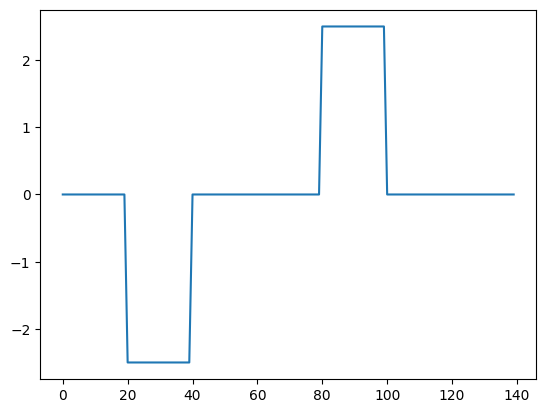

In [7]:
Ref_traj = torch.tensor(np.repeat(np.array([0,-1,0,0,1,0,0]),20))*2.5
plt.plot(Ref_traj)


In [10]:
#  === Initial Conditions: Values at time = k ==================
torch.set_default_dtype(torch.float32)
u_hat = torch.zeros((P))
x_past = torch.zeros((2,window))
u_past = torch.zeros((1,window))
error_past = torch.zeros((2,window))
x_current = torch.zeros((2,1))
x_sys_current = x_current
x_hat_current = x_current

K_ac = torch.tensor([[-0.2068,-0.6756]])


RobustMPC = RMPC_pytorch_iteration(u_hat=u_hat,
                     x_past=x_past,
                     u_past=u_past,
                     window=window,
                     P=P,
                     x_current=x_current,
                     K_ac=K_ac,
                     sys_params=nominal_params,
                     optim_obj=RMPC_obj_TiDE_pytorch,
                     penalty_obj = penalty_obj,
                     include_u_hist=False,
                     NN_model = nominal_TiDE,
                     NN_forward=TiDE_forward,
                     LossParam = BarParam,
                     error_past=error_past,
                     constraint=None,
                     tube_model=tube_TiDE,
                     tube_params=tube_params,
                     u_tighten=True,
                     global_state = global_state
                     )

# Run MPC

n_steps = 120

for i in range(n_steps):
    SP_hat = Ref_traj[i:i+P]
    RobustMPC.run_one_step(SP_hat=SP_hat, RMPC=True)

# Plots    
RobustMPC.Plot_standard(Ref_traj,n_steps,plot_traj_steps=n_steps,show_constraints=True)
RobustMPC.Plot_input_output(show_constraint=True)


tensor(-5.6581, grad_fn=<AddBackward0>)
tensor(-6.6589, grad_fn=<AddBackward0>)
tensor(-6.6589, grad_fn=<AddBackward0>)
tensor(-6.6591, grad_fn=<AddBackward0>)
tensor(-6.6591, grad_fn=<AddBackward0>)
tensor(-6.6591, grad_fn=<AddBackward0>)
tensor(-6.6591, grad_fn=<AddBackward0>)
tensor(-6.6591, grad_fn=<AddBackward0>)
tensor(-6.6591, grad_fn=<AddBackward0>)
tensor(-5.6572, grad_fn=<AddBackward0>)
tensor(-6.6594, grad_fn=<AddBackward0>)
tensor(-6.6594, grad_fn=<AddBackward0>)
tensor(-6.6596, grad_fn=<AddBackward0>)
tensor(-6.6596, grad_fn=<AddBackward0>)
tensor(-6.6596, grad_fn=<AddBackward0>)
tensor(-6.6596, grad_fn=<AddBackward0>)
tensor(-6.6596, grad_fn=<AddBackward0>)
tensor(-5.6559, grad_fn=<AddBackward0>)
tensor(-6.6465, grad_fn=<AddBackward0>)
tensor(-6.6465, grad_fn=<AddBackward0>)
tensor(-6.6467, grad_fn=<AddBackward0>)
tensor(-6.6467, grad_fn=<AddBackward0>)
tensor(-6.6467, grad_fn=<AddBackward0>)
tensor(-6.6467, grad_fn=<AddBackward0>)
tensor(-5.6424, grad_fn=<AddBackward0>)


IndexError: list index out of range

IndexError: index 16 is out of bounds for dimension 1 with size 16

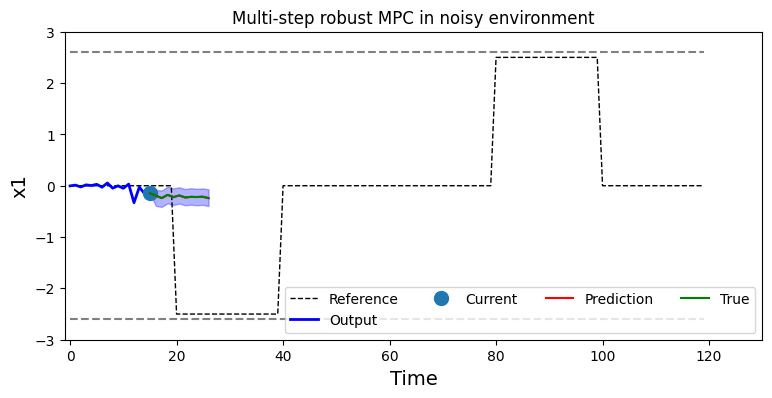

In [11]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

MPC_iters = n_steps

# Set up the figure
fig, ax = plt.subplots(figsize=(9, 4), dpi=100)
ax.set_xlabel("Time",fontsize=14)
ax.set_ylabel("x1",fontsize=14)
plt.xlim(-1,MPC_iters + P)
plt.ylim(-3,3)
plt.plot(np.ones((n_steps,1))*2.6,'--',color='gray')
plt.plot(np.ones((n_steps,1))*-2.6,'--',color='gray')


Ref_traj_plot, = ax.plot(Ref_traj[:n_steps],'--', linewidth=1,color = 'black',label="Reference")
real_output_plot, = ax.plot([],[], label="Output",color='blue',linewidth=2)
point_current, = ax.plot([], [], ".", markersize=20, label="Current")
line_pred, = ax.plot([], [], "-", linewidth=1.5, color="red", label="Prediction")
line_true, = ax.plot([], [], "-", linewidth=1.5, color="green", label="True")

ax.legend(loc='lower right', ncol=4)

tube_x1 = ax.fill_between(np.linspace(0,P+1,P+1),np.zeros((P+1))*1,np.zeros((P+1))*1,alpha=0.3, label="Tube")

# Function to update the plot in each iteration
def update(iter):
    real_output_plot.set_data(np.linspace(0, len(RobustMPC.real_output[0,:iter])-1, len(RobustMPC.real_output[0,:iter])), RobustMPC.real_output[0,:iter])
    point_current.set_data(iter, RobustMPC.real_output[0,iter])
    pred = np.concatenate((RobustMPC.real_output[0,iter].reshape(-1,1),RobustMPC.x_hat_horizon_save[iter,:].reshape(-1,1)),axis=0).flatten()
    line_pred.set_data(np.linspace(iter,iter+P+1,P+1),pred)
    line_true.set_data(np.linspace(iter,iter+P+1,P+1),np.concatenate((RobustMPC.real_output[0,iter].reshape(-1,1),RobustMPC.true_pred_output_x1_save[iter,:].reshape(-1,1)),axis=0))
    tube_upper = np.concatenate((np.zeros((1,1)),RobustMPC.error_past_x1_upper[iter].reshape(-1,1)),axis=0).flatten()
    tube_lower = np.concatenate((np.zeros((1,1)),RobustMPC.error_past_x1_lower[iter].reshape(-1,1))).flatten()
    ax.collections[-1].remove()
    ax.fill_between(np.linspace(iter,iter+P+1,P+1),tube_upper+pred,tube_lower+pred,alpha=0.3, color='blue')
    plt.title(f"Multi-step robust MPC in noisy environment")
    return real_output_plot, point_current, line_pred, line_true
# Create animation
animation = FuncAnimation(fig, update, frames=MPC_iters,  blit=True)

# # Show the animation
HTML(animation.to_jshtml())
plt.rcParams["animation.html"] = "jshtml"
animation.save('vanilla_MPC_in_noisy_environment.gif', writer='imagemagick', fps=5)
animation

### MPC without constraint

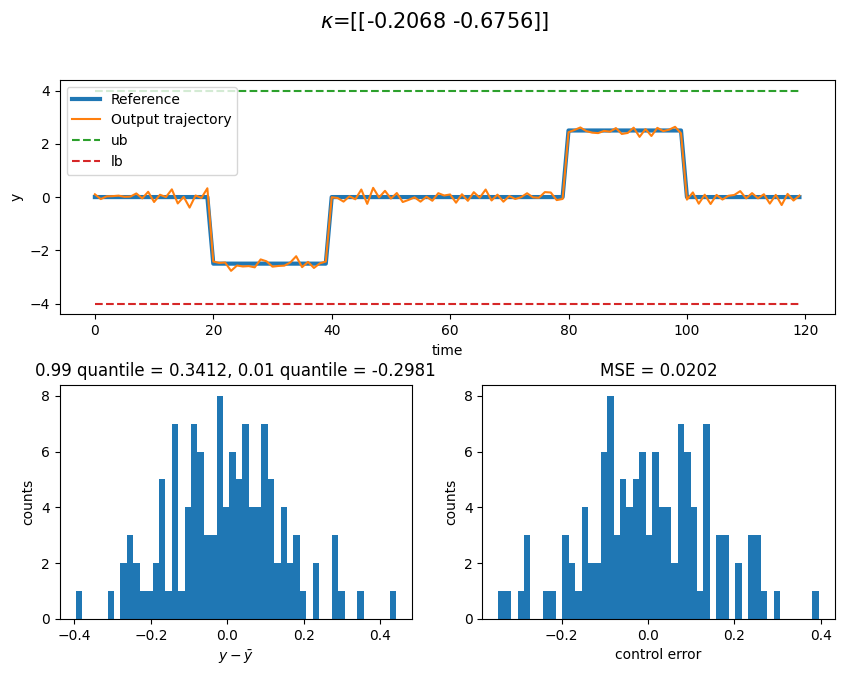

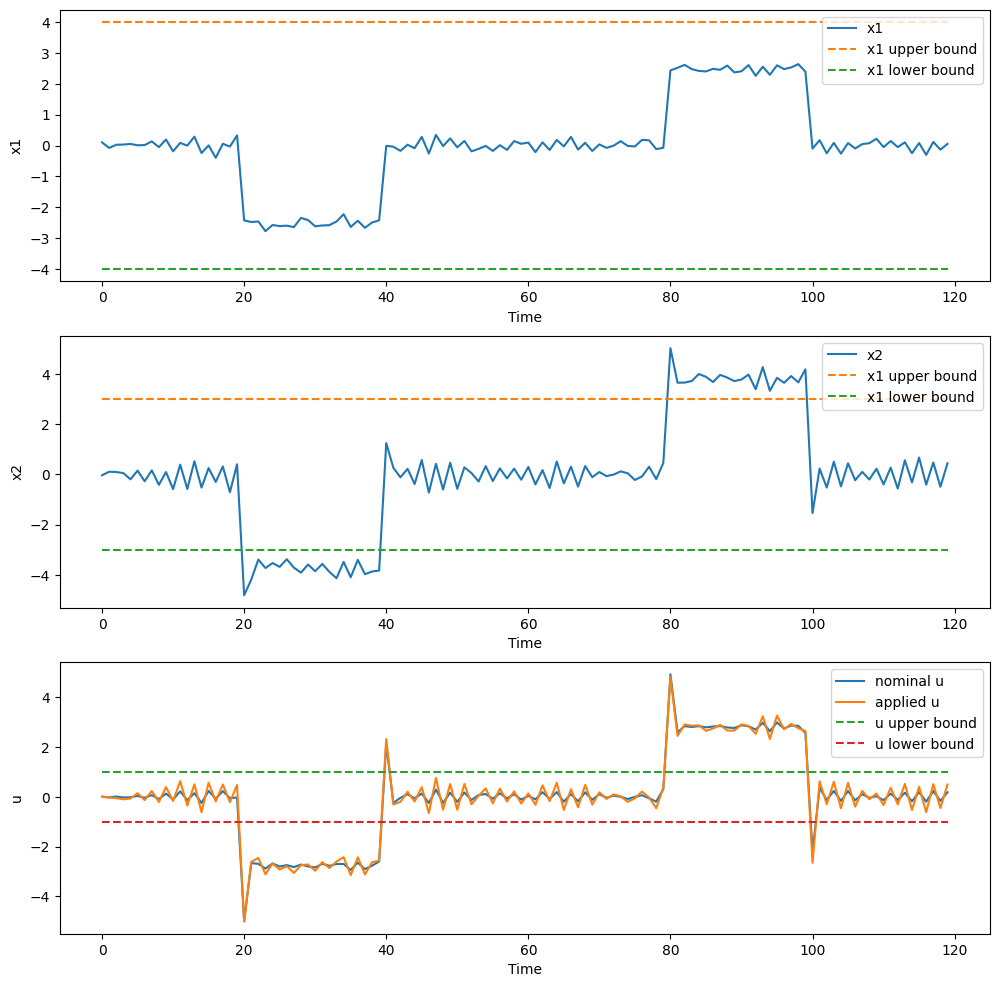

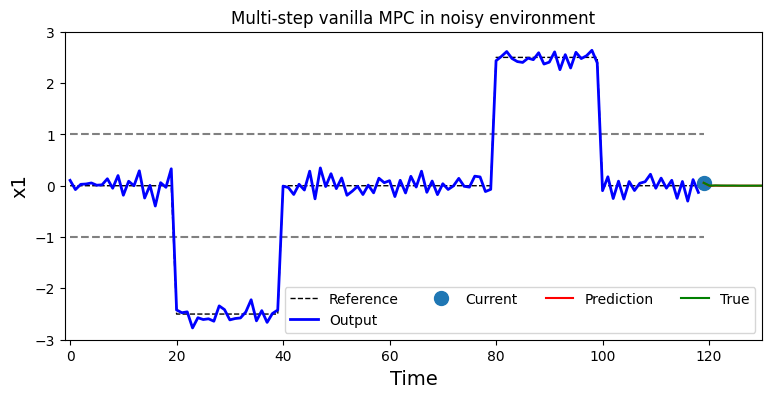

In [ ]:
#  === Initial Conditions: Values at time = k ==================
u_hat = np.zeros((P))
x_past = np.zeros((2,window))
u_past = np.zeros((1,window))
error_past = np.zeros((2,window))
x_current = np.zeros((2,1))
x_sys_current = x_current
x_hat_current = x_current

K_ac = np.array([[-0.2068,-0.6756]])

vanilla_MPC = RMPC_iteration(u_hat=u_hat,
                     x_past=x_past,
                     u_past=u_past,
                     window=window,
                     P=P,
                     x_current=x_current,
                     K_ac=K_ac,
                     sys_params=nominal_params,
                     optim_obj=RMPC_obj_TiDE,
                     include_u_hist=False,
                     NN_model = nominal_TiDE,
                     NN_forward=TiDE_forward,
                     error_past=error_past,
                     constraint=None,
                     tube_model=tube_TiDE,
                     u_tighten=None
                     )


# Run MPC

n_steps = 120

for i in range(n_steps):
    SP_hat = Ref_traj[i:i+P]
    vanilla_MPC.run_one_step(SP_hat=SP_hat)

# Plots    
vanilla_MPC.Plot_standard(Ref_traj,n_steps,plot_traj_steps=n_steps,show_constraints=True)
vanilla_MPC.Plot_input_output(show_constraint=True)


from matplotlib.animation import FuncAnimation
from IPython.display import HTML

MPC_iters = n_steps

# Set up the figure
fig, ax = plt.subplots(figsize=(9, 4), dpi=100)
ax.set_xlabel("Time",fontsize=14)
ax.set_ylabel("x1",fontsize=14)
plt.xlim(-1,MPC_iters + P)
plt.ylim(-3,3)
plt.plot(np.ones((n_steps,1))*1,'--',color='gray')
plt.plot(np.ones((n_steps,1))*-1,'--',color='gray')


Ref_traj_plot, = ax.plot(Ref_traj[:n_steps],'--', linewidth=1,color = 'black',label="Reference")
real_output_plot, = ax.plot([],[], label="Output",color='blue',linewidth=2)
point_current, = ax.plot([], [], ".", markersize=20, label="Current")
line_pred, = ax.plot([], [], "-", linewidth=1.5, color="red", label="Prediction")
line_true, = ax.plot([], [], "-", linewidth=1.5, color="green", label="True")

ax.legend(loc='lower right', ncol=4)


# Function to update the plot in each iteration
def update(iter):
    real_output_plot.set_data(np.linspace(0, len(vanilla_MPC.real_output[0,:iter])-1, len(vanilla_MPC.real_output[0,:iter])), vanilla_MPC.real_output[0,:iter])
    point_current.set_data(iter, vanilla_MPC.real_output[0,iter])
    pred = np.concatenate((vanilla_MPC.real_output[0,iter].reshape(-1,1),vanilla_MPC.x_hat_horizon_save[iter,:].reshape(-1,1)),axis=0).flatten()
    line_pred.set_data(np.linspace(iter,iter+P+1,P+1),pred)
    line_true.set_data(np.linspace(iter,iter+P+1,P+1),np.concatenate((vanilla_MPC.real_output[0,iter].reshape(-1,1),vanilla_MPC.true_pred_output_x1_save[iter,:].reshape(-1,1)),axis=0))

    plt.title(f"Multi-step vanilla MPC in noisy environment")
    return real_output_plot, point_current, line_pred, line_true
# Create animation
animation = FuncAnimation(fig, update, frames=MPC_iters,  blit=True)

# # Show the animation
HTML(animation.to_jshtml())
plt.rcParams["animation.html"] = "jshtml"
animation.save('vanilla_MPC_in_noisy_environment.gif', writer='imagemagick', fps=5)
animation

### MPC with constraint and tube

In [ ]:
import random

# Set a random seed
random_seed = 513 # 43  # You can use any integer value as the seed
random.seed(random_seed)

#  === Initial Conditions: Values at time = k ==================
u_hat = np.zeros((P))
x_past = np.zeros((2,window))
u_past = np.zeros((1,window))
error_past = np.zeros((2,window))
x_current = np.zeros((2,1))
x_sys_current = x_current
x_hat_current = x_current

K_ac = np.array([[-0.2068,-0.6756]])

MPC_w_constraint_tube = RMPC_iteration(u_hat=u_hat,
                     x_past=x_past,
                     u_past=u_past,
                     window=window,
                     P=P,
                     x_current=x_current,
                     K_ac=K_ac,
                     sys_params=nominal_params,
                     optim_obj=RMPC_obj_TiDE,
                     include_u_hist=False,
                     NN_model = nominal_TiDE,
                     NN_forward=TiDE_forward,
                     error_past=error_past,
                     constraint=x_bound_check_wrapper,
                     tube_model=tube_TiDE,
                     u_tighten=True
                     )


# Run MPC

n_steps = 120

for i in range(n_steps):
    SP_hat = Ref_traj[i:i+P]
    MPC_w_constraint_tube.run_one_step(SP_hat=SP_hat)

# Plots    
MPC_w_constraint_tube.Plot_standard(Ref_traj,n_steps,plot_traj_steps=n_steps,show_constraints=True)
MPC_w_constraint_tube.Plot_input_output(show_constraint=True)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 10 and the array at index 1 has size 1

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

MPC_iters = n_steps

# Set up the figure
fig, ax = plt.subplots(figsize=(9, 4), dpi=100)
ax.set_xlabel("Time",fontsize=14)
ax.set_ylabel("x1",fontsize=14)
plt.xlim(-1,MPC_iters + P)
plt.ylim(-5,5)
plt.plot(np.ones((n_steps,1))*4,'--',color='gray')
plt.plot(np.ones((n_steps,1))*-4,'--',color='gray')


Ref_traj_plot, = ax.plot(Ref_traj[:n_steps],'--', linewidth=1,color = 'black',label="Reference")
real_output_plot, = ax.plot([],[], label="Output",color='blue',linewidth=2)
point_current, = ax.plot([], [], ".", markersize=20, label="Current")
line_pred, = ax.plot([], [], "-", linewidth=1.5, color="red", label="Prediction")
line_true, = ax.plot([], [], "-", linewidth=1.5, color="green", label="True")


tube_x1 = ax.fill_between(np.linspace(0,P+1,P+1),np.zeros((P+1))*1,np.zeros((P+1))*1,alpha=0.3, label="Tube")

ax.legend(loc='lower right', ncol=4)


# Function to update the plot in each iteration
def update(iter):
    real_output_plot.set_data(np.linspace(0, len(MPC_w_constraint_tube.real_output[0,:iter])-1, len(MPC_w_constraint_tube.real_output[0,:iter])), MPC_w_constraint_tube.real_output[0,:iter])
    point_current.set_data(iter, MPC_w_constraint_tube.real_output[0,iter])
    pred = np.concatenate((MPC_w_constraint_tube.real_output[0,iter].reshape(-1,1),MPC_w_constraint_tube.x_hat_horizon_save[iter,:].reshape(-1,1)),axis=0).flatten()
    line_pred.set_data(np.linspace(iter,iter+P+1,P+1),pred)
    line_true.set_data(np.linspace(iter,iter+P+1,P+1),np.concatenate((MPC_w_constraint_tube.real_output[0,iter].reshape(-1,1),MPC_w_constraint_tube.true_pred_output_x1_save[iter,:].reshape(-1,1)),axis=0))
    tube_upper = np.concatenate((np.zeros((1,1)),MPC_w_constraint_tube.error_past_x1_upper[iter].reshape(-1,1)),axis=0).flatten()
    tube_lower = np.concatenate((np.zeros((1,1)),MPC_w_constraint_tube.error_past_x1_lower[iter].reshape(-1,1))).flatten()
    ax.collections[-1].remove()
    ax.fill_between(np.linspace(iter,iter+P+1,P+1),tube_upper+pred,tube_lower+pred,alpha=0.3, color='blue')
    plt.title(f"step {iter}")
    return real_output_plot, point_current, line_pred, line_true
# Create animation
animation = FuncAnimation(fig, update, frames=MPC_iters,  blit=True)

# # Show the animation
HTML(animation.to_jshtml())
plt.rcParams["animation.html"] = "jshtml"
animation.save('animation_with_correct_tubes.gif', writer='imagemagick', fps=5)
animation

### MPC with constraint without tube

In [ ]:
import random

# Set a random seed
random_seed = 43  # You can use any integer value as the seed
random.seed(random_seed)

#  === Initial Conditions: Values at time = k ==================
u_hat = np.zeros((P))
x_past = np.zeros((2,window))
u_past = np.zeros((1,window))
error_past = np.zeros((2,window))
x_current = np.zeros((2,1))
x_sys_current = x_current
x_hat_current = x_current

K_ac = np.array([[-0.2068,-0.6756]])

MPC_w_constraint_no_tube = RMPC_iteration(u_hat=u_hat,
                     x_past=x_past,
                     u_past=u_past,
                     window=window,
                     P=P,
                     x_current=x_current,
                     K_ac=K_ac,
                     sys_params=nominal_params,
                     optim_obj=RMPC_obj_TiDE,
                     include_u_hist=False,
                     NN_model = nominal_TiDE,
                     NN_forward=TiDE_forward,
                     error_past=error_past,
                     constraint=x_bound_check_wrapper_wo_tube,
                     tube_model=tube_TiDE,
                     u_tighten=None
                     )


# Run MPC

n_steps = 120

for i in range(n_steps):
    SP_hat = Ref_traj[i:i+P]
    MPC_w_constraint_no_tube.run_one_step(SP_hat=SP_hat)

# Plots    
MPC_w_constraint_no_tube.Plot_standard(Ref_traj,n_steps,plot_traj_steps=n_steps,show_constraints=True)
MPC_w_constraint_no_tube.Plot_input_output(show_constraint=True)

## MPC with soft constraint penalty

In [ ]:
import random

# Set a random seed
random_seed = 513 # 43  # You can use any integer value as the seed
random.seed(random_seed)

#  === Initial Conditions: Values at time = k ==================
u_hat = np.zeros((P))
x_past = np.zeros((2,window))
u_past = np.zeros((1,window))
error_past = np.zeros((2,window))
x_current = np.zeros((2,1))
x_sys_current = x_current
x_hat_current = x_current

K_ac = np.array([[-0.2068,-0.6756]])

MPC_w_penalty_tube = RMPC_iteration(u_hat=u_hat,
                     x_past=x_past,
                     u_past=u_past,
                     window=window,
                     P=P,
                     x_current=x_current,
                     K_ac=K_ac,
                     sys_params=nominal_params,
                     optim_obj=RMPC_obj_TiDE_w_penalty,
                     include_u_hist=False,
                     NN_model = nominal_TiDE,
                     NN_forward=TiDE_forward,
                     error_past=error_past,
                     constraint=None,
                     tube_model=tube_TiDE,
                     u_tighten=True
                     )


# Run MPC

n_steps = 120

for i in range(n_steps):
    SP_hat = Ref_traj[i:i+P]
    MPC_w_penalty_tube.run_one_step_w_penalty(SP_hat=SP_hat)

# Plots    
MPC_w_penalty_tube.Plot_standard(Ref_traj,n_steps,plot_traj_steps=n_steps,show_constraints=True)
MPC_w_penalty_tube.Plot_input_output(show_constraint=True)

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

MPC_iters = n_steps

# Set up the figure
fig, ax = plt.subplots(figsize=(9, 4), dpi=100)
ax.set_xlabel("Time",fontsize=14)
ax.set_ylabel("x1",fontsize=14)
plt.xlim(-1,MPC_iters + P)
plt.ylim(-5,5)
plt.plot(np.ones((n_steps,1))*4,'--',color='gray')
plt.plot(np.ones((n_steps,1))*-4,'--',color='gray')


Ref_traj_plot, = ax.plot(Ref_traj[:n_steps],'--', linewidth=1,color = 'black',label="Reference")
real_output_plot, = ax.plot([],[], label="Output",color='blue',linewidth=2)
point_current, = ax.plot([], [], ".", markersize=20, label="Current")
line_pred, = ax.plot([], [], "-", linewidth=1.5, color="red", label="Prediction")
line_true, = ax.plot([], [], "-", linewidth=1.5, color="green", label="True")


tube_x1 = ax.fill_between(np.linspace(0,P+1,P+1),np.zeros((P+1))*1,np.zeros((P+1))*1,alpha=0.3, label="Tube")

ax.legend(loc='lower right', ncol=4)


# Function to update the plot in each iteration
def update(iter):
    real_output_plot.set_data(np.linspace(0, len(MPC_w_penalty_tube.real_output[0,:iter])-1, len(MPC_w_penalty_tube.real_output[0,:iter])), MPC_w_penalty_tube.real_output[0,:iter])
    point_current.set_data(iter, MPC_w_penalty_tube.real_output[0,iter])
    pred = np.concatenate((MPC_w_penalty_tube.real_output[0,iter].reshape(-1,1),MPC_w_penalty_tube.x_hat_horizon_save[iter,:].reshape(-1,1)),axis=0).flatten()
    line_pred.set_data(np.linspace(iter,iter+P+1,P+1),pred)
    line_true.set_data(np.linspace(iter,iter+P+1,P+1),np.concatenate((MPC_w_penalty_tube.real_output[0,iter].reshape(-1,1),MPC_w_penalty_tube.true_pred_output_x1_save[iter,:].reshape(-1,1)),axis=0))
    tube_upper = np.concatenate((np.zeros((1,1)),MPC_w_penalty_tube.error_past_x1_upper[iter].reshape(-1,1)),axis=0).flatten()
    tube_lower = np.concatenate((np.zeros((1,1)),MPC_w_penalty_tube.error_past_x1_lower[iter].reshape(-1,1))).flatten()
    ax.collections[-1].remove()
    ax.fill_between(np.linspace(iter,iter+P+1,P+1),tube_upper+pred,tube_lower+pred,alpha=0.3, color='blue')
    plt.title(f"step {iter}")
    return real_output_plot, point_current, line_pred, line_true
# Create animation
animation = FuncAnimation(fig, update, frames=MPC_iters,  blit=True)

# # Show the animation
HTML(animation.to_jshtml())
plt.rcParams["animation.html"] = "jshtml"
animation.save('animation_with_correct_tubes_penalty.gif', writer='imagemagick', fps=5)
animation

In [ ]:
vanilla_MPC_x1 = vanilla_MPC.real_output[0,:]
MPC_w_constraint_no_tube_x1 = MPC_w_constraint_no_tube.real_output[0,:]
MPC_w_constraint_tube_x1 = MPC_w_constraint_tube.real_output[0,:]
MPC_w_penalty_tube_x1 = MPC_w_penalty_tube.real_output[0,:]

output_save = np.vstack((vanilla_MPC_x1, MPC_w_constraint_no_tube_x1,MPC_w_constraint_tube_x1, MPC_w_penalty_tube_x1, Ref_traj[0:120]))

filename = 'compare_data.csv'
np.savetxt(filename,output_save,delimiter=',')

# MPC with soft constraint and Augmented Lagrangian penalty

In [ ]:
#  === Initial Conditions: Values at time = k ==================
torch.set_default_dtype(torch.float32)
u_hat = torch.zeros((P))
x_past = torch.zeros((2,window))
u_past = torch.zeros((1,window))
error_past = torch.zeros((2,window))
x_current = torch.zeros((2,1))
x_sys_current = x_current
x_hat_current = x_current

K_ac = torch.tensor([[-0.2068,-0.6756]])

RobustMPC = RMPC_pytorch_iteration(u_hat=u_hat,
                     x_past=x_past,
                     u_past=u_past,
                     window=window,
                     P=P,
                     x_current=x_current,
                     K_ac=K_ac,
                     sys_params=nominal_params,
                     optim_obj=RMPC_obj_TiDE_pytorch,
                     penalty_obj = penalty_obj,
                     include_u_hist=False,
                     NN_model = nominal_TiDE,
                     NN_forward=TiDE_forward,
                     LossParam = LossParam,
                     error_past=error_past,
                     constraint=x_bound_check,
                     tube_model=tube_TiDE,
                     tube_params=tube_params,
                     u_tighten=None
                     )

# Run MPC

n_steps = 120

for i in range(n_steps):
    SP_hat = Ref_traj[i:i+P]
    RobustMPC.run_one_step(SP_hat=SP_hat)

# Plots    
RobustMPC.Plot_standard(Ref_traj,n_steps,plot_traj_steps=n_steps,show_constraints=True)
RobustMPC.Plot_input_output(show_constraint=True)


from matplotlib.animation import FuncAnimation
from IPython.display import HTML

MPC_iters = n_steps

# Set up the figure
fig, ax = plt.subplots(figsize=(9, 4), dpi=100)
ax.set_xlabel("Time",fontsize=14)
ax.set_ylabel("x1",fontsize=14)
plt.xlim(-1,MPC_iters + P)
plt.ylim(-1.5,1.5)
plt.plot(np.ones((n_steps,1))*1,'--',color='gray')
plt.plot(np.ones((n_steps,1))*-1,'--',color='gray')


Ref_traj_plot, = ax.plot(Ref_traj[:n_steps],'--', linewidth=1,color = 'black',label="Reference")
real_output_plot, = ax.plot([],[], label="Output",color='blue',linewidth=2)
point_current, = ax.plot([], [], ".", markersize=20, label="Current")
line_pred, = ax.plot([], [], "-", linewidth=1.5, color="red", label="Prediction")
line_true, = ax.plot([], [], "-", linewidth=1.5, color="green", label="True")

ax.legend(loc='lower right', ncol=4)


# Function to update the plot in each iteration
def update(iter):
    real_output_plot.set_data(np.linspace(0, len(vanilla_MPC.real_output[0,:iter])-1, len(vanilla_MPC.real_output[0,:iter])), vanilla_MPC.real_output[0,:iter])
    point_current.set_data(iter, vanilla_MPC.real_output[0,iter])
    pred = np.concatenate((vanilla_MPC.real_output[0,iter].reshape(-1,1),vanilla_MPC.x_hat_horizon_save[iter,:].reshape(-1,1)),axis=0).flatten()
    line_pred.set_data(np.linspace(iter,iter+P+1,P+1),pred)
    line_true.set_data(np.linspace(iter,iter+P+1,P+1),np.concatenate((vanilla_MPC.real_output[0,iter].reshape(-1,1),vanilla_MPC.true_pred_output_x1_save[iter,:].reshape(-1,1)),axis=0))

    plt.title(f"Multi-step vanilla MPC in noisy environment")
    return real_output_plot, point_current, line_pred, line_true
# Create animation
animation = FuncAnimation(fig, update, frames=MPC_iters,  blit=True)

# # Show the animation
HTML(animation.to_jshtml())
plt.rcParams["animation.html"] = "jshtml"
animation.save('vanilla_MPC_in_noisy_environment.gif', writer='imagemagick', fps=5)
animation

In [ ]:
g_global